## Notebook Imports

In [67]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

## Constants

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1/'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2/'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/'

# For categories
SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'

## Reading Files

In [3]:
# Reading the file
stream = open(EXAMPLE_FILE, encoding='latin-1')

# Reading file context line by line
message = stream.read()

# Close stream after reading
stream.close()

In [4]:
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
import sys

In [6]:
sys.getfilesystemencoding()

'utf-8'

In [7]:
# To read only message body
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

# Read all lines in file
for line in stream:
    if is_body:
        lines.append(line)
    
    # To detect a line space between header and a body
    elif line == '\n':
        is_body = True


stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Functions

In [8]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [9]:
for i in generate_squares(5):
    print(i, end='-> ')

0-> 1-> 4-> 9-> 16-> 

## Email body extraction

In [10]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            # Extracts email from a particular file
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            # Read all lines in a file
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True


            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body

In [11]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [12]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.tail()

,MESSAGE,CATEGORY
01311.43bfe86df65d53c5f7ca2365dc12582b,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00851.dc5452f80ba0bb8481dfc48f70380c4d,<html>\n\n<HEAD> \n\n<TITLE>creditfix</TITLE> ...,1
01328.b23902de23cb3ca1f3334517282372b2,Hello:\n\n\n\nAre you satisfied with your ISP?...,1
01244.9ef966101737a6fc27d8965def288d70,<html><HEAD><TITLE>creditfix</TITLE> \n\n</HEA...,1
00788.b98a23c07d59156d172683fc29b80661,<HTML><HEAD></HEAD><BODY><b><FONT SIZE=3D4>In ...,1


In [13]:
spam_emails.shape

(1898, 2)

In [14]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.tail()

,MESSAGE,CATEGORY
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0
00747.352d424267d36975a7b40b85ffd0885e,"If you run Pick, and then use the ""New FTOC"" b...",0


In [15]:
ham_emails.shape

(3901, 2)

In [16]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is:', data.shape)
data.head()

Shape of entire dataframe is: (5799, 2)


,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [17]:
data.tail()

,MESSAGE,CATEGORY
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0
00747.352d424267d36975a7b40b85ffd0885e,"If you run Pick, and then use the ""New FTOC"" b...",0


## Data Cleaning: Checking for Missing Values

In [18]:
# Check if any message body is null
data['MESSAGE'].isnull().values.any()

False

In [19]:
# Check if there are empty emails (String len zero)
(data.MESSAGE.str.len() == 0).any()

True

In [20]:
# Count how many are empty str
(data.MESSAGE.str.len() == 0).sum()

3

In [21]:
# Check number of entries with null/none values?
# Will return 0, because it is considering empty str also
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [22]:
# Return index names where it is zero
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [23]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

### Remove System Files Entries from Dataframe

In [24]:
data = data.drop('cmds')
data.shape

(5796, 2)

### Add Document IDs to track Emails in Dataset

In [25]:
document_ids = range(0, len(data.index))

# Adding new col for DOC_ID
data['DOC_ID'] = document_ids

In [26]:
# Adding a new col for FILE_NAMES(index)
data['FILE_NAMES'] = data.index
data.head()

,MESSAGE,CATEGORY,DOC_ID,FILE_NAMES
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,0,00249.5f45607c1bffe89f60ba1ec9f878039a
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1,1,00373.ebe8670ac56b04125c25100a36ab0510
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1,2,00214.1367039e50dc6b7adb0f2aa8aba83216
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,3,00210.050ffd105bd4e006771ee63cabc59978
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1,4,00033.9babb58d9298daa2963d4f514193d7d6


In [27]:
# Replacing index from filenames to 'DOC_ID'
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAMES
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


In [28]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAMES
DOC_ID,,,
5791,"I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
5792,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,01127.841233b48eceb74a825417d8d918abf8
5794,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0,01178.5c977dff972cd6eef64d4173b90307f0
5795,"If you run Pick, and then use the ""New FTOC"" b...",0,00747.352d424267d36975a7b40b85ffd0885e


## Save to File using Pandas

In [29]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualized (Pie Charts)

In [30]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [31]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

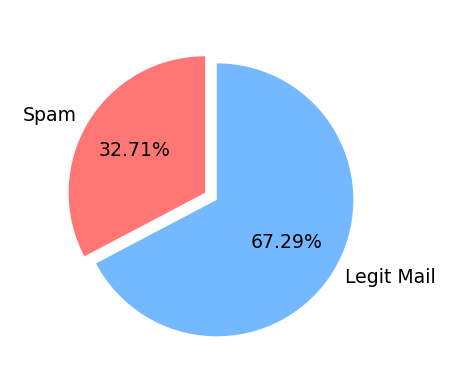

In [32]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2), dpi=226)   #dpi=display pixel per inch
plt.pie(sizes, labels=category_names,
        textprops={'fontsize': 6}, startangle=90,  #startangle = rotate pie
        autopct='%1.2f%%', colors=custom_colours,  #autopct = format for % label
        explode=[0,0.1])    # explode =distance of pie slice
plt.show()

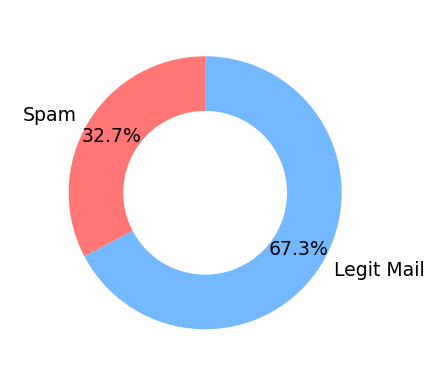

In [33]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2), dpi=226)   #dpi=display pixel per inch
plt.pie(sizes, labels=category_names,
        textprops={'fontsize': 6}, startangle=90,  #startangle = rotate pie
        autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8)  #Percent label moving out

#Add a circle as a donut illusion to the center of pie chart
centre_circle = plt.Circle((0,0), radius=0.6, fc='white') #Give coordinates and radius
plt.gca().add_artist(centre_circle)   #gca = get_current_axis


plt.show()

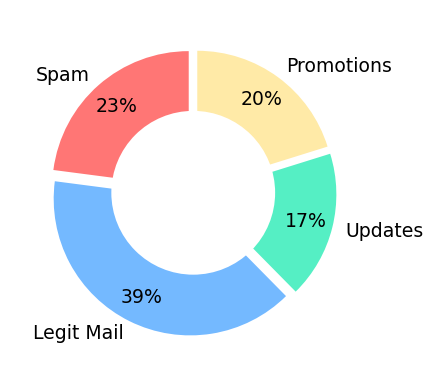

In [34]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=226)   #dpi=display pixel per inch
plt.pie(sizes, labels=category_names,
        textprops={'fontsize': 6}, startangle=90,  #startangle = rotate pie
        autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8,  #Percent label moving out
        explode=offset)  

#Add a circle as a donut illusion to the center of pie chart
centre_circle = plt.Circle((0,0), radius=0.6, fc='white') #Give coordinates and radius
plt.gca().add_artist(centre_circle)   #gca = get_current_axis


plt.show()

# Natural Language Processing

## Test Pre-Processing

In [36]:
# Convert to lower case
msg = 'All work an no play makes Jack a dull boy.'
msg.lower()

'all work an no play makes jack a dull boy.'

### Download the NLTK Resource (Tokenizer & Stopwords)

In [44]:
#nltk.download('punkt')

In [46]:
#nltk.download('stopwords')

## Tokenising

In [42]:
msg = 'All work an no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [52]:
stop_words = set(stopwords.words('english'))

In [53]:
type(stop_words)

set

In [58]:
if 'faiq' in stop_words: print('Found it!') 
else: print('Not founded!')

Not founded!


In [63]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
#
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Words Stems and Stemming

In [70]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []

for word in words:
    #To remove punctuations
    if word.isalpha():
        
        #To check stopwords
        if word not in stop_words:
            
            # Stem the stemmed word and then append it
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
        
#
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing Punctuation 

In [68]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. ?? \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []

for word in words:
    if word not in stop_words:
        # Stem the stemmed word and then append it
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
#
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', '?', '?', 'nobodi', 'expect', 'spanish', 'inquisit', '!']
